# CNN Classification Demo Notebook

In this notebook, we will delve into advanced image classification techniques using PyTorch. We will cover four essential chapters, each focusing on a critical aspect of building, training, and utilizing state-of-the-art deep learning models for image classification tasks.

## Chapter 1: Load and View the Data

In this notebook we'll also be showing how to use torchvision to handle datasets that are not part of `torchvision.datasets`. Specificially we'll be using the 2011 version of the [CUB200](http://www.vision.caltech.edu/visipedia/CUB-200-2011.html) dataset. This is a dataset with 200 different species of birds. Each species has around 60 images, which are around 500x500 pixels each. Our goal is to correctly determine which species an image belongs to - a 200-dimensional image classification problem.

As this is a relatively small dataset - ~12,000 images compared to CIFAR10's 60,000 images - we'll be using a pre-trained model and then performing transfer learning using discriminative fine-tuning.

**Note:** on the CUB200 dataset website there is a warning about some of the images in the dataset also appearing in ImageNet, which our pre-trained model was trained on. If any of those images are in our test set then this would be a form of "information leakage" as we are evaluating our model on images it has been trained on. However, the GitHub gist linked at the end of [this](https://guopei.github.io/2016/Overlap-Between-Imagenet-And-CUB/) article states that only 43 of the images appear in ImageNet. Even if they all ended up in the test set this would only be ~1% of all images in there so would have a negligible impact on performance.


### Data Processing

As always, we'll start by importing all the necessary modules. We have a few new imports here:
- `lr_scheduler` for using the one cycle learning rate scheduler
- `namedtuple` for handling ResNet configurations
- `os` and `shutil` for handling custom datasets

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.optim.lr_scheduler import _LRScheduler
import torch.utils.data as data

import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models

from sklearn import decomposition
from sklearn import manifold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

import copy
from collections import namedtuple
import os
import random
import shutil
import time

Next, we'll set the random seeds for reproducability.

In [2]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

We'll be using our own dataset instead of using one provided by `torchvision.datasets`.

The url of the CUB200-2011 dataset can be found on its [website](http://www.vision.caltech.edu/visipedia/CUB-200-2011.html). However, the dataset is now hosted on Google Drive which has problems with files exceeding their download quota.

Instead, we'll download the dataset from [Kaggle](https://www.kaggle.com) using the [kaggle-api](https://github.com/Kaggle/kaggle-api) which needs to be installed with `pip install kaggle`.

First, we need to have a Kaggle account in order to generate an API key. Once we're logged on to Kaggle, we need to go to `https://www.kaggle.com/<username>/account` and click `Generate New API Token` which will download a `kaggle.json` file. Place this at `~/.kaggle/kaggle.json` (or, if you're on Windows, at `C:\Users\<Windows-username>\.kaggle\kaggle.json`).

If we are using Google Colab, an alternative is simply set the environment variables `KAGGLE_USERNAME` and `KAGGLE_KEY` to their respective values. This is what we do below.

Next, we'll download the dataset from where it is hosted on Kaggle, at: https://www.kaggle.com/veeralakrishna/200-bird-species-with-11788-images. This is done with `!kaggle datasets download <kaggle-url> --unzip`, where the `<kaggle-url>` is the dataset URL after the `kaggle.com` part, which is `veeralakrishna/200-bird-species-with-11788-images` for this dataset.

[`datasets.utils`](https://github.com/pytorch/vision/blob/master/torchvision/datasets/utils.py) contains some functionality for downloading and extract data which means we don't have to write it ourselves.

We use the `extract_archive` function, which extracts a file to a given root folder. We should now have a `data/CUB_200_2011` folder which contains our entire dataset.

In [5]:
kaggle_route = False
!wget https://s3.amazonaws.com/fast-ai-imageclas/CUB_200_2011.tgz

--2024-07-29 23:40:47--  https://s3.amazonaws.com/fast-ai-imageclas/CUB_200_2011.tgz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 16.182.37.168, 16.182.37.40, 54.231.137.24, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|16.182.37.168|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1150585339 (1.1G) [application/x-tar]
Saving to: ‘CUB_200_2011.tgz’

CUB_200_2011.tgz    100%[===================>]   1.07G  6.16MB/s    in 2m 45s  

2024-07-29 23:43:32 (6.66 MB/s) - ‘CUB_200_2011.tgz’ saved [1150585339/1150585339]



In [6]:
ROOT = 'data'
datasets.utils.extract_archive('CUB_200_2011.tgz', ROOT)

'data'

##### Appendix. Use Kaggle ... 

In [ ]:
if kaggle_route == True:
    # Run this cell and select the kaggle.json file downloaded
    # from the Kaggle account settings page.
    from google.colab import files
    files.upload()

    # Let's make sure the kaggle.json file is present.
    !ls -lha kaggle.json

    # Next, install the Kaggle API client.
    !pip install -q kaggle

    # The Kaggle API client expects this file to be in ~/.kaggle,
    # so move it there.
    !mkdir -p ~/.kaggle
    !cp kaggle.json ~/.kaggle/

    # This permissions change avoids a warning on Kaggle tool startup.
    !chmod 600 ~/.kaggle/kaggle.json

    # List available datasets.
    !kaggle datasets list

    # REPLACE THESE WITH YOUR OWN KAGGLE USERNAME AND KEY
    os.environ['KAGGLE_USERNAME'] = 'YOUR_KAGGLE_USERNAME_HERE'
    os.environ['KAGGLE_KEY'] = 'YOUR_KAGGLE_KEY_HERE'

    !pip install kaggle
    !kaggle datasets download veeralakrishna/200-bird-species-with-11788-images --unzip

    ROOT = 'data'

    datasets.utils.extract_archive('CUB_200_2011.tgz', ROOT)

####
To handle using custom datasets, torchvision provides a [`datasets.ImageFolder`](https://pytorch.org/vision/stable/datasets.html#torchvision.datasets.ImageFolder) class.

`ImageFolder` expects data to be stored in the following way:

```
root/class_x/xxy.png
root/class_x/xxz.jpg

root/class_y/123.jpeg
root/class_y/nsdf3.png
root/class_y/asd932_.jpg
```

That is, each folder in the root directory is the name of a class, and within each of those folders are the images that correspond to that class. The images in the downloaded dataset are currently in the form of:

```
CUB_200_2011/images/class_a/image_1.jpg
CUB_200_2011/images/class_a/image_2.jpg

CUB_200_2011/images/class_b/image_1.jpg
CUB_200_2011/images/class_b/image_2.jpg

CUB_200_2011/images/class_c/image_1.jpg
CUB_200_2011/images/class_c/image_2.jpg
```

This means we could call `datasets.ImageFolder(root = '.data/CUB_200_2011/images)` and it would load all of the data. However, we want to split our data into train and test splits. This could be done with `data.random_split`, which we have used in the past to create our validation sets - but we will show how to manually create a `train` and `test` folder and store the relevant images in those folders. This way means that we only need to create a train/test split once and re-use it each time we re-run the notebook

We first set a `TRAIN_RATIO` which will decide what percentage of the images per class are used to make up the training set, with the remainder making up the test set. We create a `train` and `test` folder within the `CUB_200_2011` folder - after first deleting them if they already exist. Then, we get a list of all classes and loop through each class. For each class we get the image names, use the first `TRAIN_RATIO` of them for the training set and the remainder for the test set. We then copy - with `shutil.copyfile` - each of the images into their respective `train` or `test` folder. It is usually better to copy, rather than move, the images to create your custom splits just in case we accidentally mess up somewhere.

After running the below cell we have our training set as:

```
CUB_200_2011/images/train/class_a/image_1.jpg
CUB_200_2011/images/train/class_a/image_2.jpg

CUB_200_2011/images/train/class_b/image_1.jpg
CUB_200_2011/images/train/class_b/image_2.jpg

CUB_200_2011/images/train/class_b/image_1.jpg
CUB_200_2011/images/train/class_b/image_2.jpg
```

and our test set as:

```
CUB_200_2011/images/test/class_a/image_48.jpg
CUB_200_2011/images/test/class_a/image_49.jpg

CUB_200_2011/images/test/class_b/image_48.jpg
CUB_200_2011/images/test/class_b/image_49.jpg

CUB_200_2011/images/test/class_c/image_48.jpg
CUB_200_2011/images/test/class_c/image_49.jpg
```

This train/test split only needs to be created once and does not need to be created again on subsequent runs.

**Note:** `ImageFolder` will only load files that have image related extensions, i.e. jpg/jpeg/png, so if there was, for example, a `.txt` file in one of the class folders then it would not be loaded with the images. If we wanted more flexibility when deciding which files to load or not - such as not loading .png images or loading images with an esoteric format - then we could either use the `is_valid_file` argument of the `ImageFolder` class or use [`DatasetFolder`](https://pytorch.org/vision/stable/datasets.html#torchvision.datasets.DatasetFolder) and provide a list of valid extensions to the `extensions` argument.

In [8]:
TRAIN_RATIO = 0.8

data_dir = os.path.join(ROOT, 'CUB_200_2011')
images_dir = os.path.join(data_dir, 'images')
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')

if os.path.exists(train_dir):
    shutil.rmtree(train_dir)
if os.path.exists(test_dir):
    shutil.rmtree(test_dir)

os.makedirs(train_dir)
os.makedirs(test_dir)

classes = os.listdir(images_dir)

for c in classes:

    class_dir = os.path.join(images_dir, c)

    images = os.listdir(class_dir)

    n_train = int(len(images) * TRAIN_RATIO)

    train_images = images[:n_train]
    test_images = images[n_train:]

    os.makedirs(os.path.join(train_dir, c), exist_ok = True)
    os.makedirs(os.path.join(test_dir, c), exist_ok = True)

    for image in train_images:
        image_src = os.path.join(class_dir, image)
        image_dst = os.path.join(train_dir, c, image)
        shutil.copyfile(image_src, image_dst)

    for image in test_images:
        image_src = os.path.join(class_dir, image)
        image_dst = os.path.join(test_dir, c, image)
        shutil.copyfile(image_src, image_dst)

Now we've got our train/test splits we can go ahead and calculate the mean and standard deviation (std) of our dataset to normalize it. We're actually going to use a pre-trained model in this notebook so will be using the mean and std desired by the pre-trained data, so we don't actually have to calculate this - however it is left as an example.

Calculating the mean and std is slightly different than when using a dataset provided by torchvision as those datasets have all of the images stored as numpy arrays in the data's `data` attribute, whilst datasets loaded by `ImageFolder` and `DataFolder` do not.

First, we load the `train_data` from the `train` folder. Remember: the mean and std must only be calculated from the training data. This will load PIL images by default so we pass the `ToTensor` transform which converts all the PIL images to tensors and scales them from 0-255 to 0-1.

We then loop through each image and calculate the mean and std across the height and width dimensions with `dim = (1,2)`, summing all the means and stds and then finding the average by dividing them by the number of examples, `len(train_data)`.

Again, this only needs to be calculated once per dataset and the means and stds calculated here can be re-used without calculating them for other runs. The exception to this is if we used a different train/test split, then we would need to calculate these again.

In [55]:
train_data = datasets.ImageFolder(root = train_dir,
                                  transform = transforms.ToTensor())

means = torch.zeros(3)
stds = torch.zeros(3)

for img, label in train_data:
    means += torch.mean(img, dim = (1,2))
    stds += torch.std(img, dim = (1,2))

means /= len(train_data)
stds /= len(train_data)

print(f'Calculated means: {means}')
print(f'Calculated stds: {stds}')

Calculated means: tensor([0.4857, 0.4993, 0.4321])
Calculated stds: tensor([0.1822, 0.1812, 0.1932])


Now to actually load our data. As we are going to be using a pre-trained model we will need to ensure that our images are the same size and have the same normalization as those used to train the model - which we find on the torchvision [models](https://pytorch.org/vision/stable/models.html) page.

We use the same data augmentation as always: randomly rotating, flipping horizontally and cropping.

In [57]:
pretrained_size = 224
pretrained_means = [0.485, 0.456, 0.406]
pretrained_stds= [0.229, 0.224, 0.225]

train_transforms = transforms.Compose([
                           transforms.Resize(pretrained_size),
                           transforms.RandomRotation(5),
                           transforms.RandomHorizontalFlip(0.5),
                           transforms.RandomCrop(pretrained_size, padding = 10),
                           transforms.ToTensor(),
                           transforms.Normalize(mean = pretrained_means,
                                                std = pretrained_stds)
                       ])

test_transforms = transforms.Compose([
                           transforms.Resize(pretrained_size),
                           transforms.CenterCrop(pretrained_size),
                           transforms.ToTensor(),
                           transforms.Normalize(mean = pretrained_means,
                                                std = pretrained_stds)
                       ])

We load our data with our transforms...

In [58]:
train_data = datasets.ImageFolder(root = train_dir,
                                  transform = train_transforms)

test_data = datasets.ImageFolder(root = test_dir,
                                 transform = test_transforms)

...create the validation split...

In [59]:
VALID_RATIO = 0.9

n_train_examples = int(len(train_data) * VALID_RATIO)
n_valid_examples = len(train_data) - n_train_examples

train_data, valid_data = data.random_split(train_data,
                                           [n_train_examples, n_valid_examples])

...and then overwrite the validation transforms, making sure to do a `deepcopy` to stop this also changing the training data transforms.

In [60]:
valid_data = copy.deepcopy(valid_data)
valid_data.dataset.transform = test_transforms

To make sure nothing has messed up we'll print the number of examples in each of the data splits - ensuring they add up to the number of examples indicated on the [CUB200-2011 dataset website](http://www.vision.caltech.edu/visipedia/CUB-200-2011.html) (11,788).

In [61]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 8472
Number of validation examples: 942
Number of testing examples: 2374


Next, we'll create the iterators with the largest batch size that fits on our GPU.

In [62]:
BATCH_SIZE = 64

train_iterator = data.DataLoader(train_data,
                                 shuffle = True,
                                 batch_size = BATCH_SIZE)

valid_iterator = data.DataLoader(valid_data,
                                 batch_size = BATCH_SIZE)

test_iterator = data.DataLoader(test_data,
                                batch_size = BATCH_SIZE)

To ensure the images have been processed correctly we can plot a few of them - ensuring we re-normalize the images so their colors look right.

In [63]:
def normalize_image(image):
    image_min = image.min()
    image_max = image.max()
    image.clamp_(min = image_min, max = image_max)
    image.add_(-image_min).div_(image_max - image_min + 1e-5)
    return image

In [64]:
def plot_images(images, labels, classes, normalize = True):

    n_images = len(images)

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure(figsize = (15, 15))

    for i in range(rows*cols):

        ax = fig.add_subplot(rows, cols, i+1)

        image = images[i]

        if normalize:
            image = normalize_image(image)

        ax.imshow(image.permute(1, 2, 0).cpu().numpy())
        label = classes[labels[i]]
        ax.set_title(label)
        ax.axis('off')

We can see the images look fine, however the names of the classes provided by the folders containing the images are a little long and sometimes overlap with neighbouring images.

In [65]:
train_data

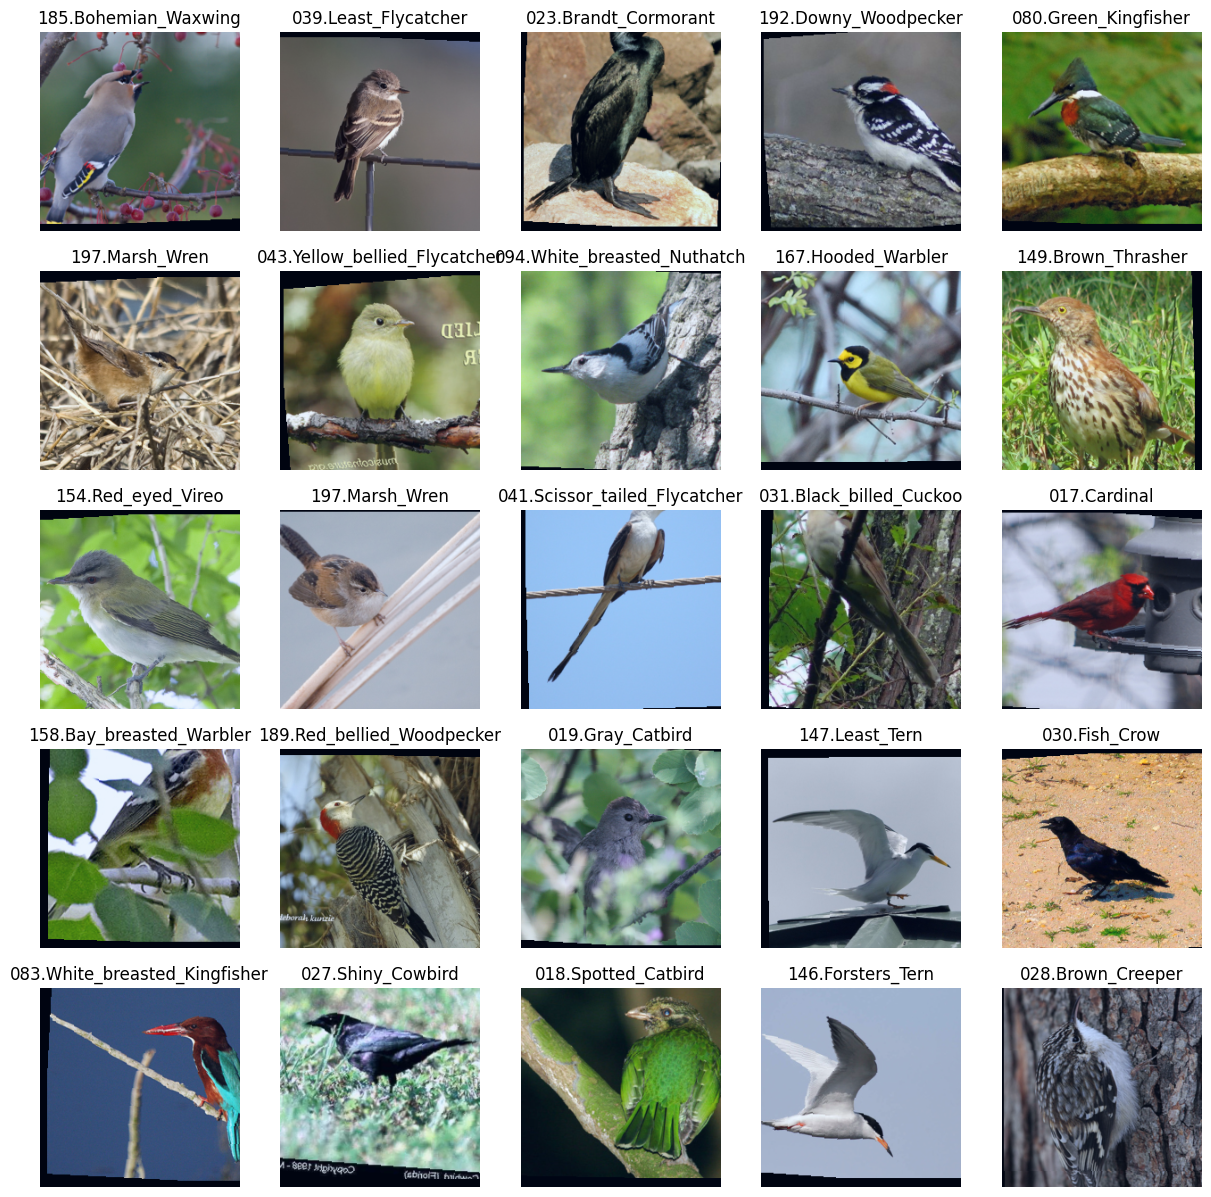

In [66]:
N_IMAGES = 25

images, labels = zip(*[(image, label) for image, label in
                           [train_data[i] for i in range(N_IMAGES)]])

classes = test_data.classes

plot_images(images, labels, classes)

## Chapter 2: Building and Training GoogleNet from Scratch

In this chapter, we will embark on building the GoogleNet, also known as Inception, from scratch using PyTorch. GoogleNet is a pioneering deep learning model that introduced the concept of the Inception module, which enables efficient computation and better performance by concatenating multiple convolutions and pooling operations. Our implementation will focus on constructing the Inception block class and the auxiliary classifier class, both of which are integral components of the architecture.
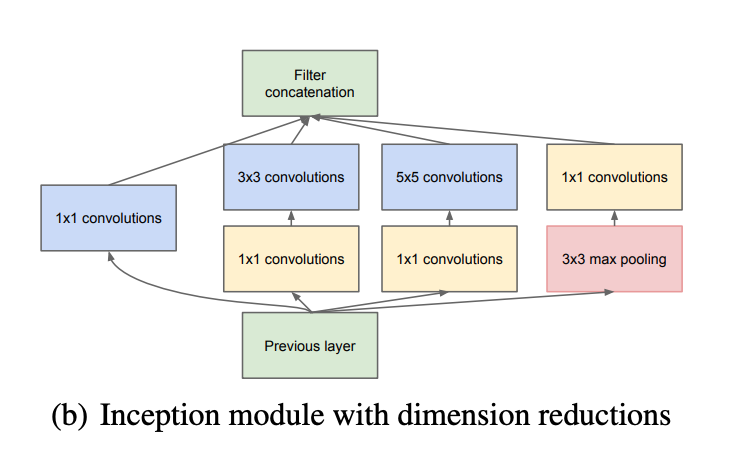

The Inception block allows the network to capture multi-level feature abstractions, while the auxiliary classifier aids in training deep networks by providing additional gradient signals. By the end of this chapter, you will gain a comprehensive understanding of the GoogleNet architecture and learn how to train it effectively for image classification tasks.


In [67]:
class Inception(nn.Module):

    def __init__(self, in_channels=3, use_auxiliary=True, num_classes=200):
        super(Inception, self).__init__()

        self.conv1 = ConvBlock(in_channels, 64, kernel_size=7, stride=2, padding=3)
        self.conv2 = ConvBlock(64, 192, kernel_size=3, stride=1, padding=1)

        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.avgpool = nn.AvgPool2d(kernel_size=7, stride=1)

        self.dropout = nn.Dropout(0.4)
        self.linear = nn.Linear(1024, num_classes)

        self.use_auxiliary = use_auxiliary
        if use_auxiliary:
            self.auxiliary4a = Auxiliary(512, num_classes)
            self.auxiliary4d = Auxiliary(528, num_classes)

        self.inception3a = InceptionBlock(192, 64, 96, 128, 16, 32, 32)
        self.inception3b = InceptionBlock(256, 128, 128, 192, 32, 96, 64)
        self.inception4a = InceptionBlock(480, 192, 96, 208, 16, 48, 64)
        self.inception4b = InceptionBlock(512, 160, 112, 224, 24, 64, 64)
        self.inception4c = InceptionBlock(512, 128, 128, 256, 24, 64, 64)
        self.inception4d = InceptionBlock(512, 112, 144, 288, 32, 64, 64)
        self.inception4e = InceptionBlock(528, 256, 160, 320, 32, 128, 128)
        self.inception5a = InceptionBlock(832, 256, 160, 320, 32, 128, 128)
        self.inception5b = InceptionBlock(832, 384, 192, 384, 48, 128, 128)

    def forward(self, x):
        y = None
        z = None

        x = self.conv1(x)
        x = self.maxpool(x)
        x = self.conv2(x)
        x = self.maxpool(x)

        x = self.inception3a(x)
        x = self.inception3b(x)
        x = self.maxpool(x)

        x = self.inception4a(x)
        if self.training and self.use_auxiliary:
            y = self.auxiliary4a(x)

        x = self.inception4b(x)
        x = self.inception4c(x)
        x = self.inception4d(x)
        if self.training and self.use_auxiliary:
            z = self.auxiliary4d(x)

        x = self.inception4e(x)
        x = self.maxpool(x)

        x = self.inception5a(x)
        x = self.inception5b(x)
        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.dropout(x)

        x = self.linear(x)

        return x, y, z

### Building Blocks of the Inception Module: ConvBlock and InceptionBlock

To build the powerful Inception architecture, we first need to understand its fundamental components: the `ConvBlock` and the `InceptionBlock`.



#### ConvBlock
The `ConvBlock` is a straightforward helper class designed to create a standard convolutional layer. It typically includes a convolutional layer followed by batch normalization and a ReLU activation function. The `ConvBlock` helps to streamline the creation of convolutions, ensuring consistency and reducing repetitive code.

In [68]:
class ConvBlock(nn.Module):

    def __init__(self, in_channels, out_channels, kernel_size, **kwargs):
        super(ConvBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, **kwargs)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()

    def forward(self, x):
        return self.relu(self.bn(self.conv(x)))

#### InceptionBlock
The `InceptionBlock` is the core building block of the Inception module. It combines multiple convolutional layers and pooling operations to capture information at different scales. Specifically, it performs:
- 1x1 convolutions to reduce dimensionality.
- 3x3 and 5x5 convolutions to capture spatial features.
- 3x3 max pooling to retain important spatial information.
The outputs of these operations are concatenated along the depth dimension, allowing the network to process multi-scale features simultaneously.

- The `InceptionBlock` relies on the `ConvBlock` to create its various convolutional paths. By using multiple `ConvBlock` instances with different kernel sizes, the `InceptionBlock` can efficiently extract and merge features from multiple receptive fields.
- `ConvBlock` is a single path convolutional unit, focusing on one specific convolution operation.
- `InceptionBlock` is a complex module that merges multiple `ConvBlock` paths and pooling operations, enabling it to learn richer and more diverse features from the input data.

In [69]:
class InceptionBlock(nn.Module):

    def __init__(self, im_channels, num_1x1, num_3x3_red, num_3x3, num_5x5_red, num_5x5, num_pool_proj):
        super(InceptionBlock, self).__init__()

        self.one_by_one = ConvBlock(im_channels, num_1x1, kernel_size=1)

        self.tree_by_three_red = ConvBlock(im_channels, num_3x3_red, kernel_size=1)
        self.tree_by_three = ConvBlock(num_3x3_red, num_3x3, kernel_size=3, padding=1)

        self.five_by_five_red = ConvBlock(im_channels, num_5x5_red, kernel_size=1)
        self.five_by_five = ConvBlock(num_5x5_red, num_5x5, kernel_size=5, padding=2)

        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
        self.pool_proj = ConvBlock(im_channels, num_pool_proj, kernel_size=1)

    def forward(self, x):
        x1 = self.one_by_one(x)

        x2 = self.tree_by_three_red(x)
        x2 = self.tree_by_three(x2)

        x3 = self.five_by_five_red(x)
        x3 = self.five_by_five(x3)

        x4 = self.maxpool(x)
        x4 = self.pool_proj(x4)

        x = torch.cat([x1, x2, x3, x4], 1)
        return x

#### Auxiliary Classifier
The Auxiliary Classifier is an additional component in the GoogleNet architecture designed to help with the training of very deep networks. Here's a deeper look into its design and purpose.

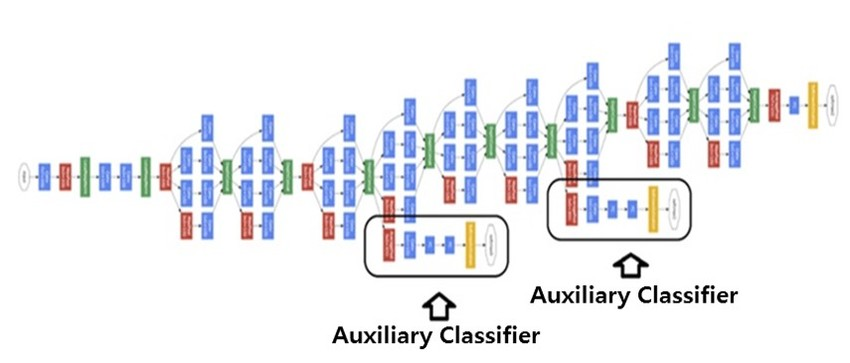

##### Purpose and Benefits

The primary purpose of the Auxiliary Classifier is to address the challenge of training very deep networks, which often suffer from the vanishing gradient problem. In the GoogleNet architecture, the Auxiliary Classifier provides the following benefits:

1. **Intermediate Supervision**:
   - The Auxiliary Classifier gives intermediate gradient signals during training, essentially acting as a form of regularization. By providing additional classification outputs at intermediate layers, it helps to ensure that gradients remain substantial throughout the network and reach the earlier layers more effectively.

2. **Smoothing Training**:
   - Auxiliary classifiers help in smoothing the flow of gradients, reducing the problem of vanishing gradients. This is particularly important for very deep networks, which can struggle to propagate back error signals without such regularization techniques.

3. **Improved Convergence**:
   - With extra supervision at intermediate stages, the network can converge faster. The additional gradient signals from the auxiliary classifiers can help improve the network's training dynamics, allowing it to learn more robust features early on in the training process.

##### Components of the Auxiliary Classifier

- **Average Pooling Layer**:
  - An average pooling operation with a kernel size of 5 and a stride of 3 is applied to reduce the spatial dimensions and focus on the most informative features.
  
- **1x1 Convolution**:
  - A 1x1 convolution (`ConvBlock`) is used to reduce the dimensionality and add non-linearity, making the features more manageable for fully connected layers.
  
- **Fully Connected Layers**:
  - The flattened features are passed through two fully connected layers (`fc1` and `fc2`) with a ReLU activation function in between and a dropout layer (with a dropout probability of 0.7) to prevent overfitting.
  
- **Classification Output**:
  - The final output is a classification layer (`fc2`) providing class scores for the auxiliary task.

In summary, the Auxiliary Classifier in GoogleNet is a vital tool for enhancing the training process of deep networks by providing additional supervision, helping with gradient flow, and ultimately contributing to more stable and efficient training.


In [70]:
class Auxiliary(nn.Module):

    def __init__(self, in_channels, num_classes):
        super(Auxiliary, self).__init__()
        self.avgpool = nn.AvgPool2d(kernel_size=5, stride=3)
        self.conv1x1 = ConvBlock(in_channels, 128, kernel_size=1)

        self.fc1 = nn.Linear(2048, 1024)
        self.fc2 = nn.Linear(1024, num_classes)

        self.dropout = nn.Dropout(0.7)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.avgpool(x)
        x = self.conv1x1(x)
        x = x.reshape(x.shape[0], -1)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

### Training the model


* `epochs` is the number of times the learning algorithm will be applied to the entire dataset. Increasing this value can result in a more accurate model but may also increase overfitting.
* `LR` (learning rate) determines how much the weights are adjusted at each step. Decreasing it makes the training process slower, allowing for finer adjustments, while increasing it makes the model learn faster but could cause the learning algorithm to miss some important patterns.
* `optimizer` is an implementation of a specific optimization technique that can be used with any other hyperparameters. The choice of optimizer and its parameters should match the specific problem to achieve optimal results.
* `device` specifies whether to use a GPU for training or not. Since GPUs are much faster than CPUs, this parameter should be set to true if possible.
* `criterion` is the loss function used to determine how well the model is performing. The choice of loss function depends on the specific problem and can have a significant impact on the quality of the model.

These hyperparameters can be adjusted according to your specific situation, and experimenting with different values might give better results. However, keep in mind that changing these values drastically may require additional tuning before arriving at an optimal configuration.



In [78]:
EPOCHS = 20
LR = 1e-3

len_classes = len(test_data.classes)
print(len_classes)
model = Inception(num_classes = len_classes)

optimizer = optim.Adam(model.parameters(), lr = LR, weight_decay=1e-4)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.CrossEntropyLoss()

model = model.to(device)
criterion = criterion.to(device)

200


One other thing we are going to implement is top-k accuracy. Our task is to classify an image into one of 200 classes of bird, however some of these classes look very similar and it is even difficult for a human to correctly label them. So, maybe we should be more lenient when calculating accuracy?

One method of solving this is using top-k accuracy, where the prediction is labelled correct if the correct label is in the top-k predictions, instead of just being the first. Our `calculate_topk_accuracy` function calculates the top-1 accuracy as well as the top-k accuracy, with $k=5$ by default.

We use `.reshape` instead of view here as the slices into tensors cause them to become non-contiguous which means `.view` throws an error. As a rule of thumb, if you are aiming to change the size/shape of sliced tensors then you should probably use `.reshape` instead of `.view`.

**Note:** our value of k should be chosen sensibly. If we had a dataset with 10 classes then a k of 5 isn't really that informative.

In [72]:
def calculate_topk_accuracy(y_pred, y, k = 5):
    with torch.no_grad():
        batch_size = y.shape[0]
        _, top_pred = y_pred.topk(k, 1)
        top_pred = top_pred.t()
        correct = top_pred.eq(y.view(1, -1).expand_as(top_pred))
        correct_1 = correct[:1].reshape(-1).float().sum(0, keepdim = True)
        correct_k = correct[:k].reshape(-1).float().sum(0, keepdim = True)
        acc_1 = correct_1 / batch_size
        acc_k = correct_k / batch_size
    return acc_1, acc_k

Next up is the training function. This is similar to all the previous notebooks, but with the addition of the `scheduler` and calculating/returning top-k accuracy.

The scheduler is updated by calling `scheduler.step()`. This should always be called **after** `optimizer.step()` or else the first learning rate of the scheduler will be skipped.

Not all schedulers need to be called after each training batch, some are only called after each epoch. In that case, the scheduler does not need to be passed to the `train` function and can be called in the main training loop.

In [73]:
def train(model, iterator, optimizer, criterion, device, use_auxiliary=True):

    epoch_loss = 0
    epoch_acc_1 = 0
    epoch_acc_5 = 0

    model.train()

    for (x, y) in iterator:

        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()

        if use_auxiliary:
            y_pred, aux1, aux2 = model(x)
            loss = criterion(y_pred, y) + 0.3 * criterion(aux1, y) + 0.3 * criterion(aux2, y) # auxiliary 영역도 loss 계산
        else:
            y_pred, _, _ = model(x)
            loss = criterion(y_pred, y)

        acc_1, acc_5 = calculate_topk_accuracy(y_pred, y)

        loss.backward()

        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc_1 += acc_1.item()
        epoch_acc_5 += acc_5.item()

    epoch_loss /= len(iterator)
    epoch_acc_1 /= len(iterator)
    epoch_acc_5 /= len(iterator)

    return epoch_loss, epoch_acc_1, epoch_acc_5

The evaluation function is also similar to previous notebooks, with the addition of the top-k accuracy.

As the one cycle scheduler should only be called after each parameter update, it is not called here as we do not update parameters whilst evaluating.

In [74]:
def evaluate(model, iterator, criterion, device):

    epoch_loss = 0
    epoch_acc_1 = 0
    epoch_acc_5 = 0

    model.eval()

    with torch.no_grad():

        for (x, y) in iterator:

            x = x.to(device)
            y = y.to(device)

            y_pred, _, _ = model(x)

            loss = criterion(y_pred, y)

            acc_1, acc_5 = calculate_topk_accuracy(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc_1 += acc_1.item()
            epoch_acc_5 += acc_5.item()

    epoch_loss /= len(iterator)
    epoch_acc_1 /= len(iterator)
    epoch_acc_5 /= len(iterator)

    return epoch_loss, epoch_acc_1, epoch_acc_5

Next, a small helper function which tells us how long an epoch has taken.

In [75]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

Finally, we can train our model!

In [79]:
best_valid_loss = float('inf')

for epoch in range(EPOCHS):

    start_time = time.monotonic()

    train_loss, train_acc_1, train_acc_5 = train(model, train_iterator, optimizer, criterion, device)
    valid_loss, valid_acc_1, valid_acc_5 = evaluate(model, valid_iterator, criterion, device)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'googlenet-from-scratch.pt')

    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc @1: {train_acc_1*100:6.2f}% | ' \
          f'Train Acc @5: {train_acc_5*100:6.2f}%')
    print(f'\tValid Loss: {valid_loss:.3f} | Valid Acc @1: {valid_acc_1*100:6.2f}% | ' \
          f'Valid Acc @5: {valid_acc_5*100:6.2f}%')

Epoch: 01 | Epoch Time: 0m 58s
	Train Loss: 8.356 | Train Acc @1:   1.36% | Train Acc @5:   6.25%
	Valid Loss: 5.444 | Valid Acc @1:   1.60% | Valid Acc @5:   9.04%


In [ ]:
model.load_state_dict(torch.load('googlenet-from-scratch.pt'))

test_loss, test_acc_1, test_acc_5 = evaluate(model, test_iterator, criterion, device)

print(f'Test Loss: {test_loss:.3f} | Test Acc @1: {test_acc_1*100:6.2f}% | ' \
      f'Test Acc @5: {test_acc_5*100:6.2f}%')

## Chapter 3: Building and Training ResNet from scratch

In this notebook we'll be implementing one of the [ResNet](https://arxiv.org/abs/1512.03385) (Residual Network) model variants. ResNet was designed for the [ImageNet challenge](http://www.image-net.org/challenges/LSVRC/), which it won in 2015.

ResNet, like VGG, also has multiple *configurations* which specify the number of layers and the sizes of those layers. Each layer is made out of *blocks*, which are made up of convolutional layers, batch normalization layers and *residual connections* (also called *skip connections* or *shortcut connections*). Confusingly, ResNets use the term "layer" to refer to both a set of blocks, e.g. "layer 1 has two blocks", and also the total number of layers within the entire ResNet, e.g. "ResNet18 has 18 layers".

A residual connection is simply a direct connection between the input of a block and the output of a block. Sometimes the residual connection has layers in it, but most of the time it does not. Below is an example block with an identity residual connection, i.e. no layers in the residual path.

![](https://github.com/bentrevett/pytorch-image-classification/blob/master/assets/resnet-skip.png?raw=1)

The different ResNet configurations are known by the total number of layers within them - ResNet18, ResNet34, ResNet50, ResNet101 and ResNet152.

![](https://github.com/bentrevett/pytorch-image-classification/blob/master/assets/resnet-table.png?raw=1)

From the table above, we can see that for ResNet18 and ResNet34 that the first block contains two 3x3 convolutional layers with 64 filters, and that ResNet18 has two of these blocks in the first layer, whilst Resnet34 has three. ResNet50, ResNet101 and ResNet152 blocks have a different structure than those in ResNet18 and ResNet34, and these blocks are called *bottleneck* blocks. Bottleneck blocks reduce the number of number of channels within the input before expanding them back out again. Below shows a standard *BasicBlock* (left) - used by ResNet18 and ResNet34 - and the *Bottleneck* block used by ResNet50, ResNet101 and ResNet152.

![](https://github.com/bentrevett/pytorch-image-classification/blob/master/assets/resnet-blocks.png?raw=1)

Why do ResNets work? The key is in the residual connections. Training incredibly deep neural networks is difficult due to the gradient signal either exploding (becoming very large) or vanishing (becoming very small) as it gets backpropagated through many layers. Residual connections allow the model to learn how to "skip" layers - by setting all their weights to zero and only rely on the residual connection. Thus, in theory, if your ResNet152 model can actually learn the desired function between input and output by only using the first 52 layers the remaining 100 layers should set their weights to zero and the output of the 52nd layer will simply pass through the residual connections unhindered. This also allows for the gradient signal to also backpropagate through those 100 layers unhindered too. This outcome could also also be achieved in a network without residual connections, the "skipped" layers would learn to set their weights to one, however adding the residual connection is more explicit and is easier for the model to learn to use these residual connections.

The image below shows a comparison between VGG-19, a convolutional neural network architecture without residual connections, and one with residual connections - ResNet34.

![](https://github.com/bentrevett/pytorch-image-classification/blob/master/assets/vgg-resnet.png?raw=1)



We'll also be using a learning rate scheduler, a PyTorch wrapper around an optimizer which allows us to dynamically alter its learning rate during training. Specifically, we'll use the *one cycle learning learning rate scheduler*, also known as *superconvergnence*, from [this](https://arxiv.org/abs/1803.09820) paper and is commonly used in the [fast.ai course](https://course.fast.ai/).



### Residual Block
Before starting with the network, we need to build a ResidualBlock that we can re-use through out the network. The block (as shown in the architecture) contains a skip connection that is an optional parameter ( `downsample` ). Note that in the `forward` , this is applied directly to the input, `x`, and not to the output, `out`.